# Coding Discussion #6
Madeline Kinnaird

# Load all the things!

#### Packages

In [147]:
#data manipulation
import pandas as pd
import numpy as np

## cleaning data
import missingno as msno
from scipy import stats

## visualizations 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

## modeling
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

## silence warnings 
import warnings
warnings.filterwarnings("ignore")

#### Data

In [95]:
## import data
test_data = pd.read_csv("../test_data.csv")
train_data = pd.read_csv("../train_data.csv")

## merge data for analysis
frames = [test_data , train_data]
data = pd.concat(frames)


In [34]:
## inspect our data a bit
data.describe()


,OBJECTID,BATHRM,HF_BATHRM,HEAT,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,...,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,LN_PRICE
count,58121.000000,58120.000000,58119.000000,58120.000000,58120.000000,58108.000000,58117.000000,58116.000000,33336.000000,58121.000000,...,58120.000000,58120.000000,58120.000000,58120.000000,58120.000000,58119.000000,58119.000000,58121.000000,58121.000000,58121.000000
mean,52061.733952,2.204026,0.649495,6.847626,1.221576,7.429459,3.429220,1931.482845,2004.261429,1969.791710,...,4.299260,3.708138,13.447350,3.963094,6.297109,1.251415,0.641116,13.277937,3171.446155,12.928077
std,31173.752433,1.067458,0.607217,5.149936,0.624942,2.370431,1.199319,83.097709,16.629371,16.934042,...,1.374629,0.746899,4.033265,3.332154,2.093512,0.662110,0.909725,4.178889,3145.140487,0.864354
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1900.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000
25%,24369.000000,1.000000,0.000000,1.000000,1.000000,6.000000,3.000000,1913.000000,2002.000000,1957.000000,...,3.000000,3.000000,14.000000,1.000000,6.000000,1.000000,0.000000,11.000000,1520.000000,12.388394
50%,51507.000000,2.000000,1.000000,7.000000,1.000000,7.000000,3.000000,1929.000000,2008.000000,1967.000000,...,4.000000,4.000000,14.000000,2.000000,6.000000,1.000000,0.000000,12.000000,2214.000000,12.994530
75%,79541.000000,3.000000,1.000000,13.000000,1.000000,8.000000,4.000000,1947.000000,2013.000000,1975.000000,...,5.000000,4.000000,14.000000,6.000000,6.000000,1.000000,1.000000,13.000000,4000.000000,13.527828
max,107154.000000,24.000000,11.000000,13.000000,6.000000,101.000000,54.000000,2018.000000,2019.000000,2018.000000,...,12.000000,6.000000,24.000000,15.000000,11.000000,44.000000,13.000000,39.000000,187301.000000,17.038378


#### A quick look:
After looking at a brief description of the data, we see some things right away. 
- There are definitely some outliers in this data that we will likely want to remove.
    - EX: A property with *24 bathrooms* might skew whatever predictor we come up with (seeing as the mean is 2 bathrooms!)
    - So we'll want to identify the outliers and address them.
- This data description only includes some of the data (the numeric data)
    - We'll need to address handling columns that are objects.



# Clean all the things!

#### Data Types
Generally speaking, it is easier to work with numeric data than objects or strings. So we'll divide the data and then determine which categorical or quantitative data should be encoded for future analysis.

In [81]:
## split data into numeric and categorical 

num = data.select_dtypes(include = ['float64', 'int64']).iloc[:,1:]
cat = data.select_dtypes(include = ['object']).iloc[:,1:]


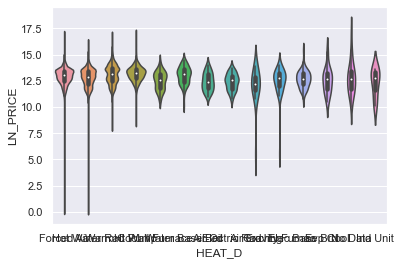

In [66]:
## test for cat variables

sns.violinplot(x = cat['HEAT_D'], y = data['LN_PRICE'])

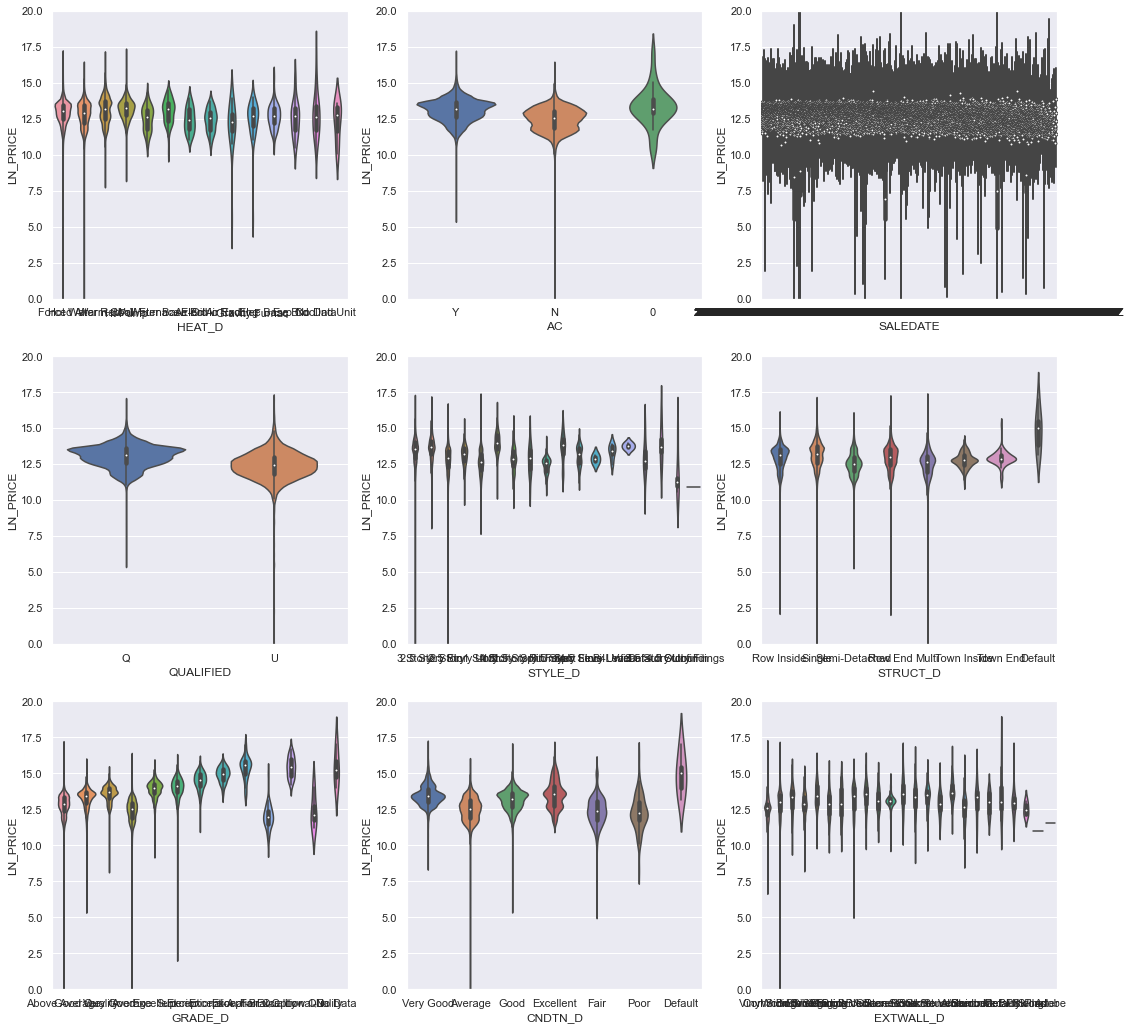

In [73]:
## loop through cat vars

plt.figure(figsize=(18,18))
for i in range(9):
    ii = '33'+str(i+1)
    plt.subplot(ii)
    feature = cat.columns.values[i]
    sns.violinplot(x = cat[feature], y = data['LN_PRICE'])
    ax=plt.gca() 
    ax.set_ylim([0,20])

#### Date Variable
Above in the violin charts, we quickly see that we need to do something about the sale date variable. Below we will decompose the date variable into more features to see if any of them are meaningful in relation to sale price.

In [96]:
## determine columns that are date columns
date_columns = [col for col in data.columns if 'DATE' in col ]

## Breaking out year, month, day in month, and day of week
for var in date_columns:
    data[var] = pd.to_datetime(data[var])
    data[var + ' Year'] = data[var].dt.year
    data[var + ' Month'] = data[var].dt.month
    data[var + ' Day'] = data[var].dt.day
    data[var + ' Day of Week'] = data[var].dt.dayofweek

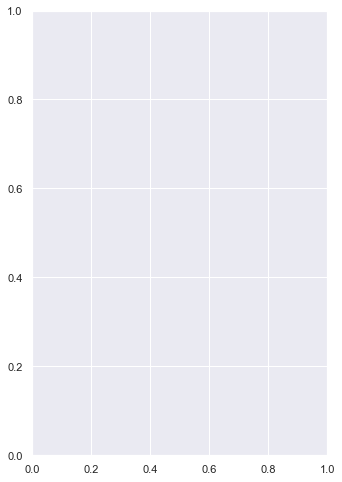

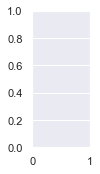

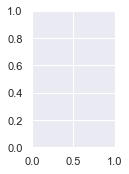

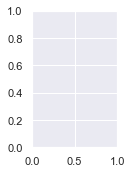

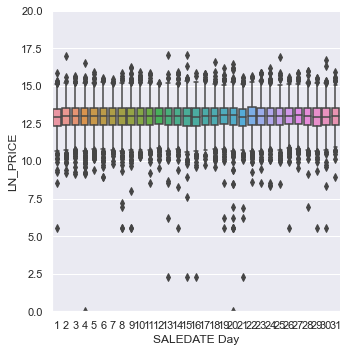

In [138]:
## add newly create date columns to our list
date_columns = [col for col in data.columns if 'DATE' in col ]


plt.figure(figsize=(18,18))
for i in range(5):
    ii = '23'+str(i+1)
    plt.subplot(ii)
    feature = date_columns[i]
    sns.catplot(x=feature, y='LN_PRICE', kind="box", data=data)
    ax=plt.gca() 
    ax.set_ylim([0,20])
    

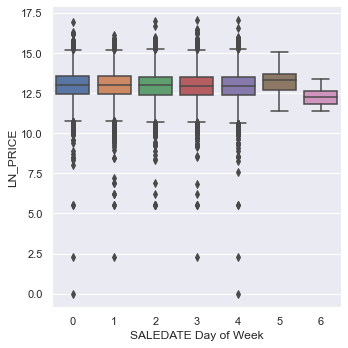

In [123]:
## day of weeek, fix above later.

sns.catplot(x='SALEDATE Day of Week', y='LN_PRICE', kind="box", data=data)

#### Encode other Categorical Variables

determine how to encode here

#### Handle Outliers

In [120]:
## IQR for each column

Q1 = num.quantile(0.25)
Q3 = num.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

BATHRM                     2.000000
HF_BATHRM                  1.000000
HEAT                      12.000000
NUM_UNITS                  0.000000
ROOMS                      2.000000
BEDRM                      1.000000
AYB                       34.000000
YR_RMDL                   11.000000
EYB                       18.000000
STORIES                    0.000000
SALE_NUM                   2.000000
GBA                      768.000000
BLDG_NUM                   0.000000
STYLE                      0.000000
STRUCT                     6.000000
GRADE                      2.000000
CNDTN                      1.000000
EXTWALL                    0.000000
ROOF                       5.000000
INTWALL                    0.000000
KITCHENS                   0.000000
FIREPLACES                 1.000000
USECODE                    2.000000
LANDAREA                2480.000000
LN_PRICE                   1.139434
SALEDATE Month             5.000000
SALEDATE Day              16.000000
SALEDATE Day of Week       2

In [121]:
## print outliers, true or false
print(num < (Q1 - 1.5 * IQR)) |(num > (Q3 + 1.5 * IQR))



       BATHRM  HF_BATHRM   HEAT  NUM_UNITS  ROOMS  BEDRM    AYB  YR_RMDL  \
0       False      False  False      False  False  False  False    False   
1       False      False  False      False  False  False  False    False   
2       False      False  False      False  False  False  False    False   
3       False      False  False      False  False  False  False    False   
4       False      False  False      False  False  False  False    False   
...       ...        ...    ...        ...    ...    ...    ...      ...   
43585   False      False  False      False  False  False  False     True   
43586   False      False  False      False  False  False  False    False   
43587   False      False  False      False  False  False  False    False   
43588   False      False  False      False  False  False  False    False   
43589   False      False  False      False  False  False  False    False   

         EYB  STORIES  ...   ROOF  INTWALL  KITCHENS  FIREPLACES  USECODE  \
0      Fal

TypeError: Cannot perform 'ror_' with a dtyped [bool] array and scalar of type [NoneType]

In [ ]:
## remove rows with outliers

data_no_outliers = num[~((num < (Q1 - 1.5 * IQR)) |(num > (Q3 + 1.5 * IQR))).any(axis=1)]
data_no_outliers.shape



In [ ]:
## create function for outliers so we can call it later when we use the split/test data

# Explore all the things!

(0.0, 20.0, 0.0, 10500.0)

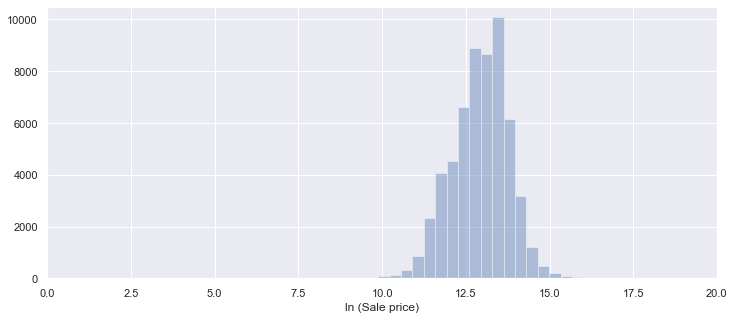

In [115]:
# Set up the matplotlib figure
plt.figure(figsize=(12,5))


sns.distplot(data['LN_PRICE'],kde=False)
plt.xlabel('ln (Sale price)')
plt.axis([0,20,0,10500])

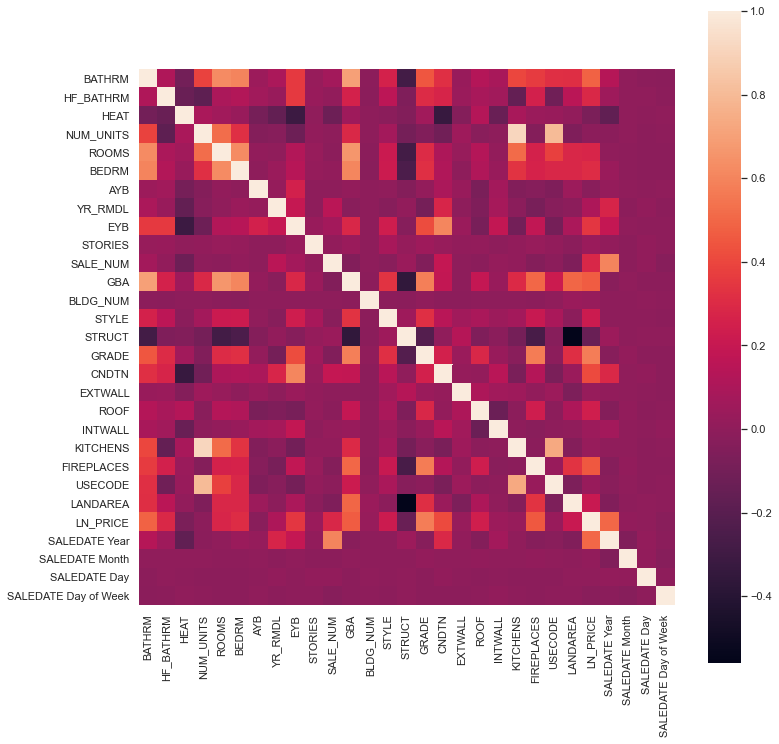

In [141]:
corr = data.select_dtypes(include = ['float64', 'int64']).iloc[:,1:].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12,12))
sns.heatmap(corr, vmax=1, square=True)
         
           


In [142]:
corr_list = corr['LN_PRICE'].sort_values(axis=0,ascending=False).iloc[1:]
corr_list

GRADE                   0.577796
SALEDATE Year           0.505839
BATHRM                  0.483131
GBA                     0.465418
FIREPLACES              0.456678
CNDTN                   0.410019
EYB                     0.346321
BEDRM                   0.309979
HF_BATHRM               0.287834
SALE_NUM                0.283959
ROOMS                   0.277035
ROOF                    0.241940
STYLE                   0.220894
LANDAREA                0.211737
YR_RMDL                 0.106361
INTWALL                 0.047907
STORIES                 0.037464
USECODE                 0.032677
KITCHENS                0.030337
EXTWALL                 0.029944
BLDG_NUM                0.028901
SALEDATE Month          0.008612
SALEDATE Day            0.004058
NUM_UNITS              -0.009180
AYB                    -0.019972
SALEDATE Day of Week   -0.020704
HEAT                   -0.068606
STRUCT                 -0.136191
Name: LN_PRICE, dtype: float64

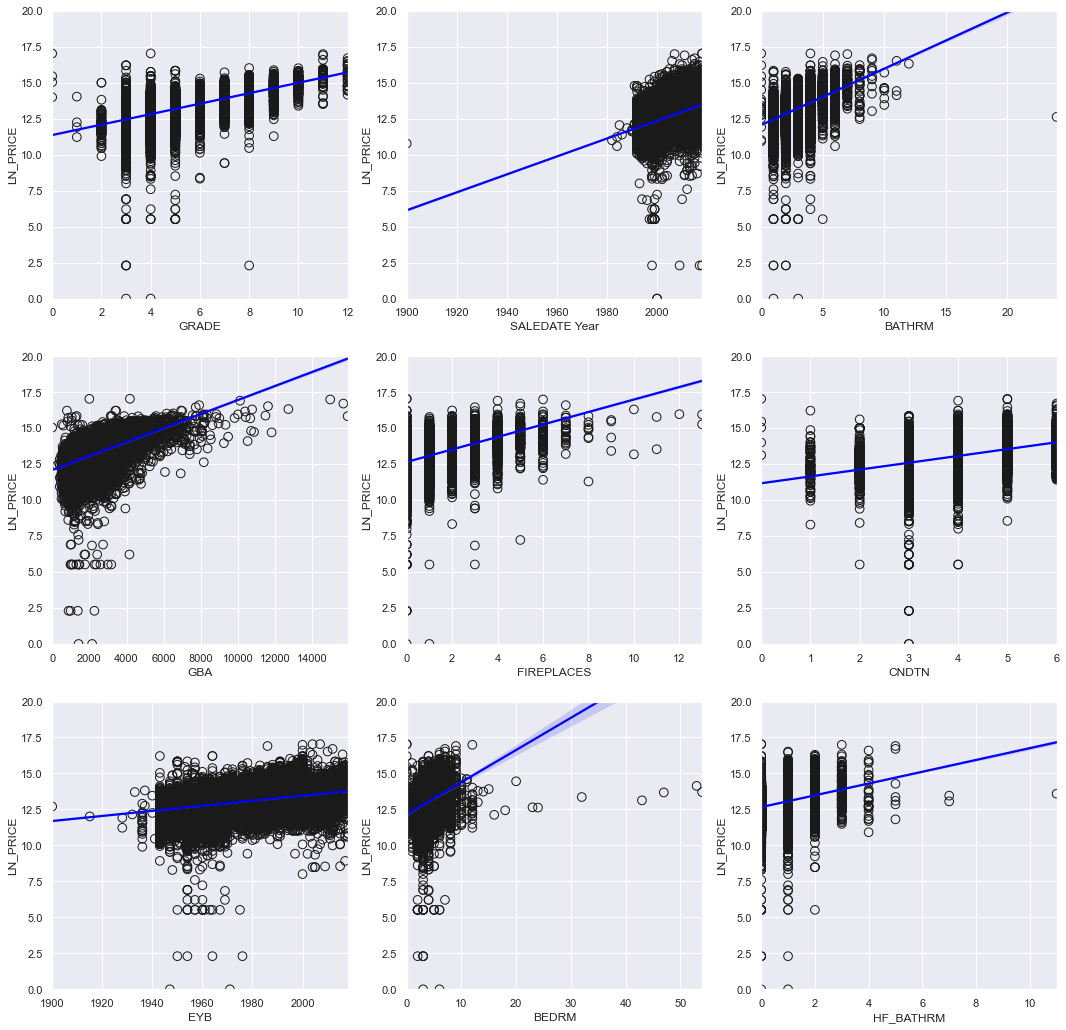

In [143]:
plt.figure(figsize=(18,18))
for i in range(9):
    ii = '33'+str(i+1)
    plt.subplot(ii)
    feature = corr_list.index.values[i]
    plt.scatter(data[feature], data['LN_PRICE'], facecolors='none',edgecolors='k',s = 75)
    sns.regplot(x = feature, y = 'LN_PRICE', data = data,scatter=False, color = 'Blue')
    ax=plt.gca() 
    ax.set_ylim([0,20])
    

^^ These will look different once we remove the outliers!!

# Feature Engineering, Importance, Selection

# Modeling

In [148]:
## make sure we're using the same data splits for each fold
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

## setting our metric for performance metrics
use_metrics = ["neg_mean_squared_error"]

###  Run the models

#### Linear Model

In [ ]:
#lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)


##### KNN

In [ ]:
#knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)


#### Decision Tree

In [ ]:
#dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)


#### Bagging

In [ ]:
#bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)


#### Random Forest

In [ ]:
#rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)
